In this Notebook, we aim at creating some DataDriven surrogate models for the simpliest 1D Poisson Equation: 

$$
- D \Delta u = 1
$$

with D the diffusion coefficient, considerer as scalar and constant over the whole domain. 

Our goal is to create params to solutions models, i.e a mapping from D to u.  

As we want to do it in a data driven manner, we first need a solver to generate data. To do so, we use an implicit finite difference method. 
$$
-D \frac{u_{i-1} -2u_i + u_{i+1}}{(\Delta x)^2} = 1
$$

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
import copy

In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'size' : 12})
rc('figure', **{'figsize' : (5, 3)})

In [3]:
sys.path.insert(1, '../..')

## Data Generation

First we need to generate data, to do so, we use the Solver module that will do everything for us in exchange for a dictionnary of params as input. 

There is some already recorded params in the config_step_1.py file 

In [4]:
from solvers.Solver import Solver
from config_step_1 import PARAMS_SOLVER

Poisson equation in a \[0, 1\] domain and 101 points for discretizations

In [5]:
PARAMS_SOLVER

{'equation': 'Poisson', 'domain': [0.0, 1.0], 'D': 1.0, 'nx': 101}

In [6]:
params_solver = copy.deepcopy(PARAMS_SOLVER)
solver = Solver(params={'solver': params_solver})

In [7]:
u = solver.solve()

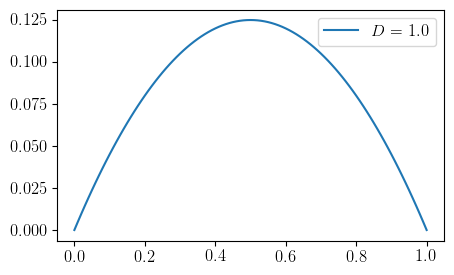

In [8]:
plt.plot(solver.x, u, label=f'$D$ = {solver.D}')
plt.legend()
plt.show()

Now let us generate a dataset using this solver

In [9]:
Dmin, Dmax = 0.1, 10
D_list = np.linspace(Dmin, Dmax, 1000).reshape(-1, 1)

In [10]:
U_sols = []
for d in D_list:
    solver.change_D(d)
    U_sols.append(solver.solve())
# U_sols = np.stack(U_sols)

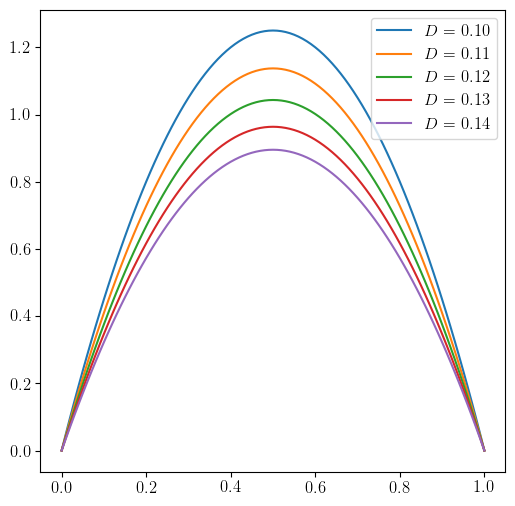

In [11]:
fig, axs = plt.subplots(1, figsize=(6, 6))
for sample in range(0, 5):
    axs.plot(solver.x, U_sols[sample], label=f'$D$ = {D_list[sample, 0]:.2f}')
plt.legend(loc=1)
plt.show()

## DataDriven surrogate models creation

Now we want to create multiple surrogate models through different methods: POD, MLP, FNO and DeepONet

In practice, we just need to call DDMethod that will handle everything for us

In [12]:
from methods.DataDrivenMethods import DDMethod

In [13]:
# chose methods that you want to use
method_names = ['POD', 'MLP', 'DEEPONET', 'PINN', 'MLPINN', 'FNO'] 

Best model parameters and optimization hyperparameters for fitting each method have already been computed using optuna (see https://optuna.readthedocs.io/en/stable/index.html), we just need to import them (see optuna folder for more detail on the training)

In [14]:
from config_step_1 import PARAMS_METHODS, HYPERPARAMS_METHODS

In [15]:
PARAMS_METHODS['MLP']

{'method_name': 'MLP',
 'layer_dims': [2, 30, 23, 20, 19, 32, 1],
 'activations': 'tanh',
 'device': device(type='cpu'),
 'seed': 123}

Create DDMethod object for each method

In [16]:
all_methods = {}
for method in method_names:
    params_method = copy.deepcopy(PARAMS_METHODS[method])
    params = {'solver': params_solver, 'method': params_method}
    all_methods[method] = DDMethod(params=params)

Load models for Neural Networks, and fit for POD

In [17]:
for method in method_names:
    hyperparams_method = copy.deepcopy(HYPERPARAMS_METHODS[method])
    if method == 'POD':
        all_methods[method].fit(hyperparameters=hyperparams_method, U=U_sols)
    elif method in ['MLP', 'DEEPONET', 'PINN', 'MLPINN', 'FNO']:
        all_methods[method].load_state_dict(f'optuna/step_1/{method}.pt')

Fitting POD
POD fitted


# Plot performances for each method

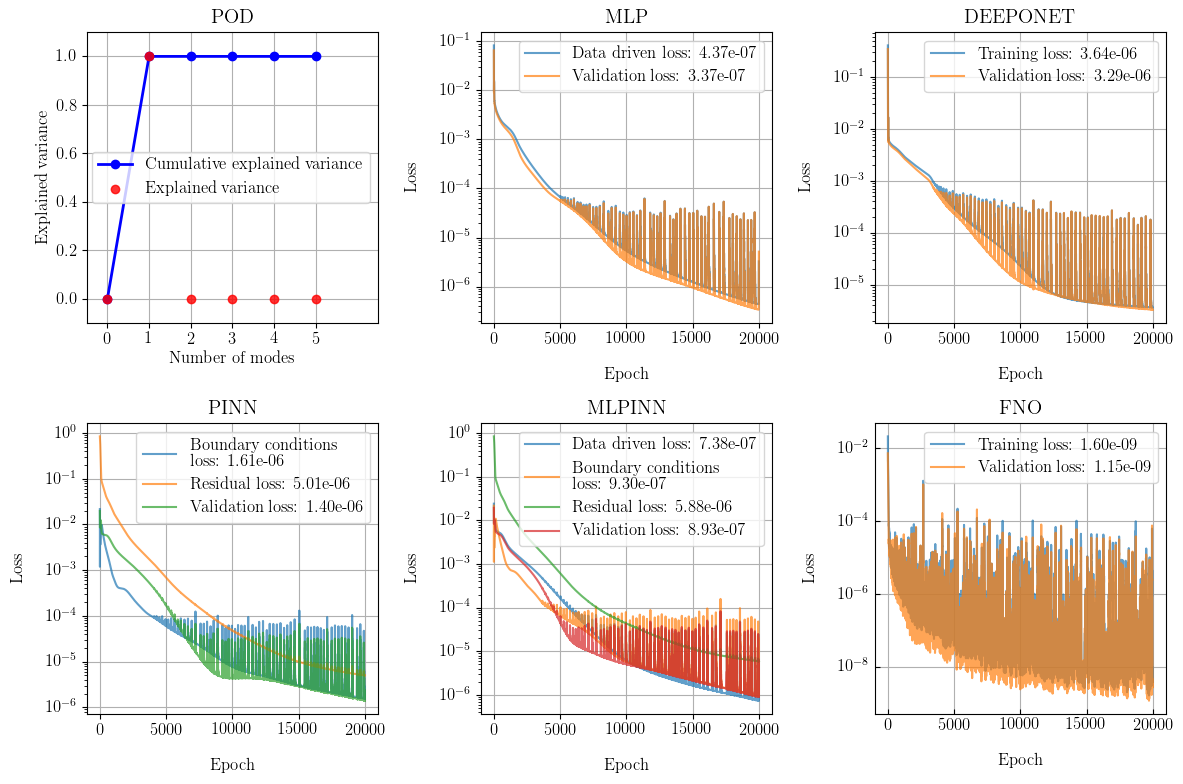

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8)) 

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    all_methods[method].plot(ax)
    ax.title.set_text(method)
    
fig.tight_layout()
plt.show()

## In distribution analysis

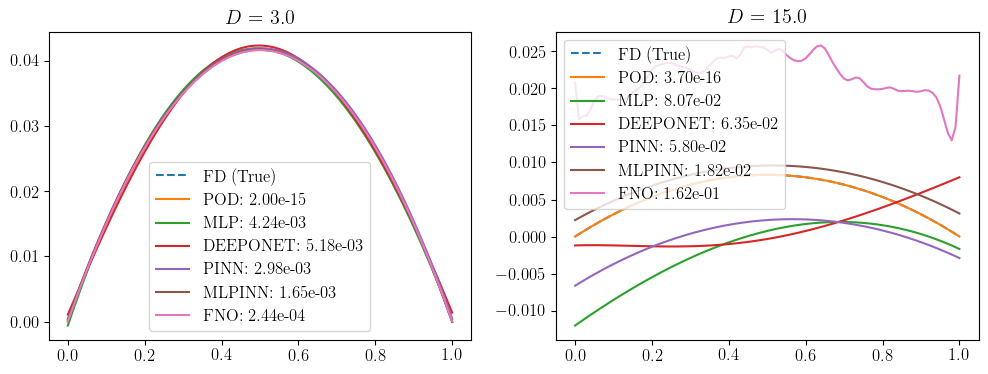

In [19]:
new_ID_D = 3.
solver.change_D(new_D=new_ID_D)
U_FD = solver.solve()

fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize= (12, 4))
ax_0.plot(solver.x, U_FD, '--', label=f'FD (True)')

for method in all_methods:
    if method == 'POD':
        U_pred = all_methods[method].apply_method(phi=new_ID_D,  D = new_ID_D).flatten()
    else:
        U_pred = all_methods[method].apply_method(phi=[new_ID_D], D=[new_ID_D]).flatten()
    ax_0.plot(solver.x, U_pred, label=f'{method}: {np.linalg.norm(U_pred - U_FD, 2):.2e}')
ax_0.title.set_text(f'$D$ = {new_ID_D}')
ax_0.legend()

new_OOD_D = 15.
solver.change_D(new_D=new_OOD_D)
U_FD = solver.solve()


ax_1.plot(solver.x, U_FD, '--', label=f'FD (True)')

for method in all_methods:
    if method == 'POD':
        U_pred = all_methods[method].apply_method(phi=new_OOD_D,  D = new_OOD_D).flatten()
    else:
        U_pred = all_methods[method].apply_method(phi=[new_OOD_D], D=[new_OOD_D]).flatten()
    ax_1.plot(solver.x, U_pred, label=f'{method}: {np.linalg.norm(U_pred - U_FD, 2):.2e}')

ax_1.title.set_text(f'$D$ = {new_OOD_D}')
ax_1.legend()
plt.show()

## Parity plot

In [20]:
#### IN DISTRIBUTION D GENERATION ######
D_list = np.linspace(0.1, 10, 1000).reshape(-1, 1)
U_list = []
for d in D_list:
    solver.change_D(new_D=d)
    U_list.append(solver.solve())

D_list = torch.Tensor(D_list)
U_list = torch.Tensor(np.stack(U_list))

    
d_train, d_val, u_train, u_val = sklearn.model_selection.train_test_split(D_list, U_list, test_size=0.2, random_state=123)

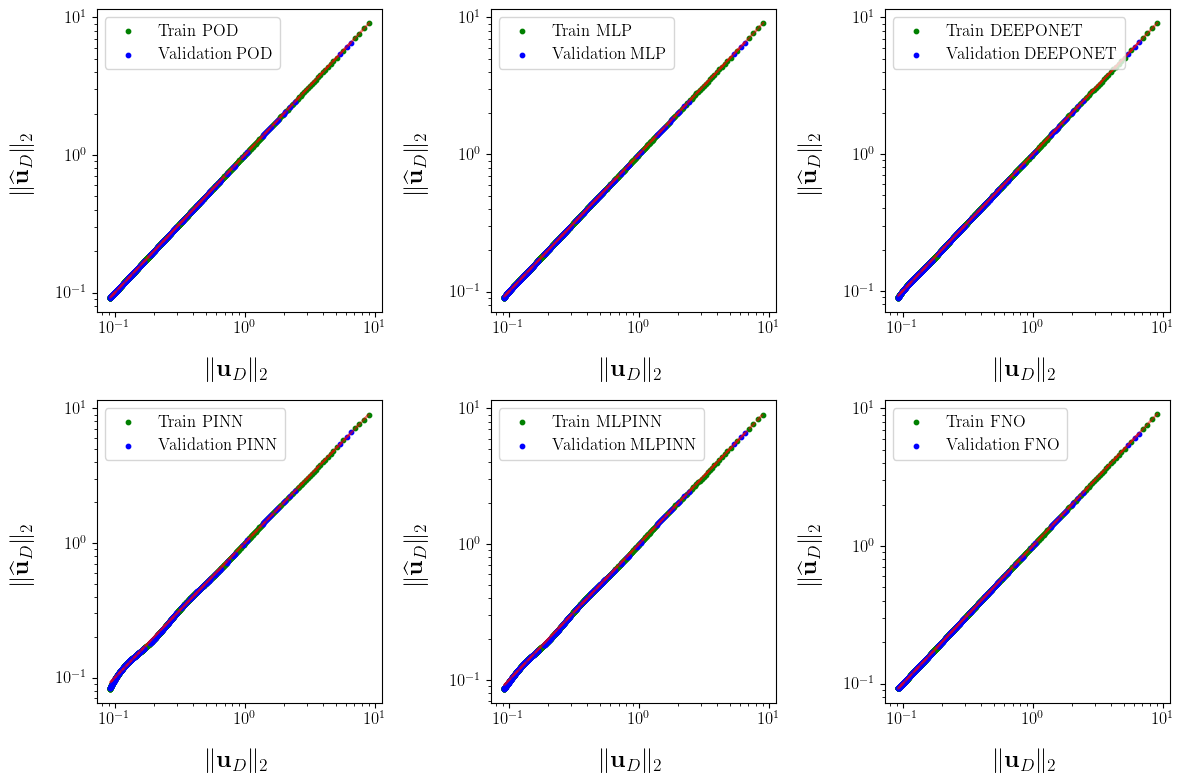

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    all_methods[method].parity_plot(U=u_train, phi=d_train, D=d_train, ax=ax, label=f'Train {method}', color='green')
    all_methods[method].parity_plot(U=u_val, phi=d_val, D=d_val, ax=ax, label=f'Validation {method}', color='blue')
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')
    
plt.tight_layout()
plt.show()

In [22]:
#### OUT OF DISTRIBUTION D GENERATION ######
OOD_D = np.concatenate([np.linspace(0.01, 0.1, 21), np.linspace(10, 101, 21)]).reshape(-1, 1)
U_OOD_FD = []
for d in OOD_D:
    solver.change_D(new_D=d)
    U_OOD_FD.append(solver.solve())

OOD_D = torch.Tensor(OOD_D).view(-1, 1)
U_OOD_FD = torch.Tensor(np.stack(U_OOD_FD))

In [23]:
#### IN DISTRIBUTION D GENERATION ######
ID_D = np.linspace(0.1, 10, 1000).reshape(-1, 1)
U_ID_FD = []
for d in ID_D:
    solver.change_D(new_D=d)
    U_ID_FD.append(solver.solve())

ID_D = torch.Tensor(ID_D).view(-1, 1)
U_ID_FD = torch.Tensor(np.stack(U_ID_FD))

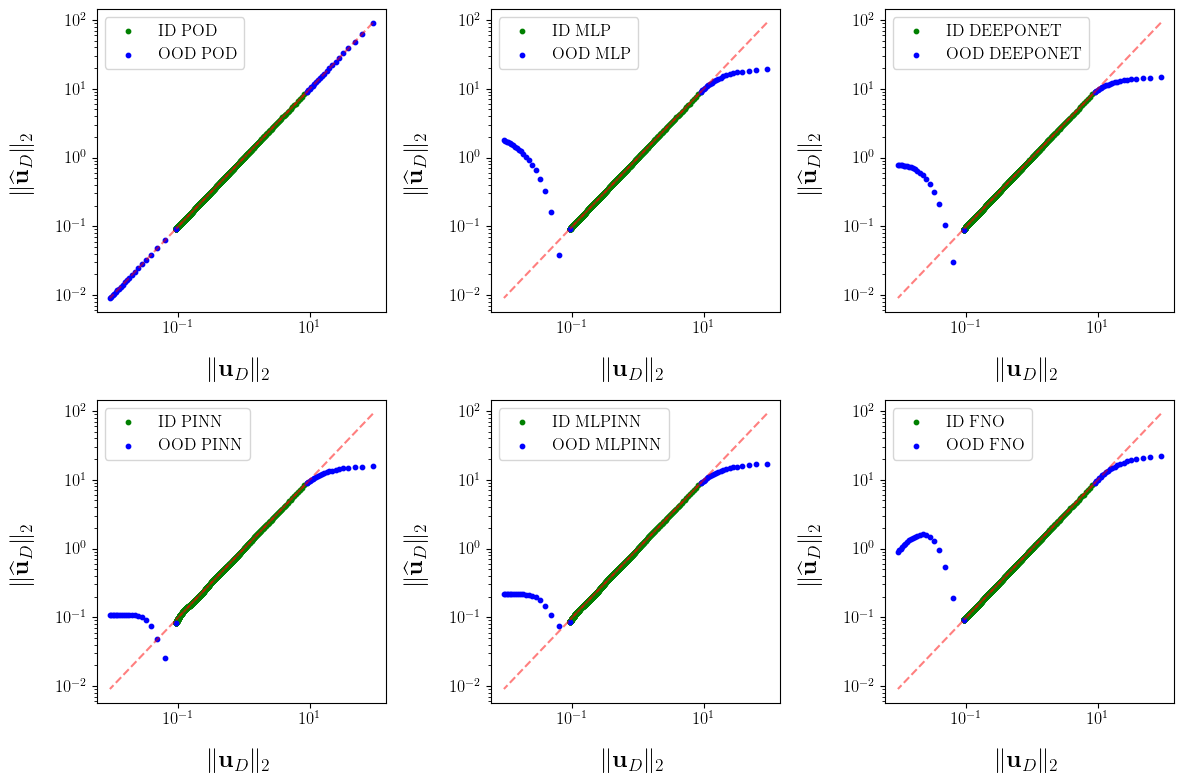

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    all_methods[method].parity_plot(U=U_ID_FD, phi = ID_D, D=ID_D, ax=ax, label=f'ID {method}', color='green')
    all_methods[method].parity_plot(U=U_OOD_FD, phi= OOD_D, D=OOD_D, ax=ax, label=f'OOD {method}', color='blue')
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')
    
plt.tight_layout()
plt.show()